### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- just use async langchain, support google vs openai vs anthropic transparently
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (newscatcher_sources, fn_initialize, fn_download_sources, fn_extract_urls,
                                 fn_verify_download, fn_extract_newscatcher, fn_filter_urls, fn_topic_clusters,
                                 fn_topic_analysis, fn_download_pages, fn_summarize_pages, fn_propose_cats,
                                 fn_compose_summary, fn_rewrite_summary, fn_is_revision_complete, fn_send_mail
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
LangChain         0.3.18
OpenAI            1.63.1
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Define LangGraph agent state graph

In [4]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [5]:
# sqlite schema to store previously processed headlines
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [6]:
# some debugging stuff, check a headline is cached properly
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [7]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("verify_download", self.verify_download)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "verify_download")
        graph_builder.add_edge("verify_download", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def verify_download(self, state: AgentState) -> AgentState:
        self.state = fn_verify_download(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newscatcher(state)
        except KeyError:
            log("Newscatcher download failed")
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )

        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    print("AIdf:")
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print("sources:")
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print(exc)

        return self.state



# Instantiate agent and run LangGraph workflow graph end to end

In [8]:
def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id


In [ ]:
before_date = None
before_date = '2025-02-16 18:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


In [ ]:
# it will stop here if check not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-02-17 11:43:46,567 - AInewsbot - INFO - Initializing with before_date=2025-02-16 18:00, do_download=False, thread_id=621c8d86eae44b18976e904747dec185


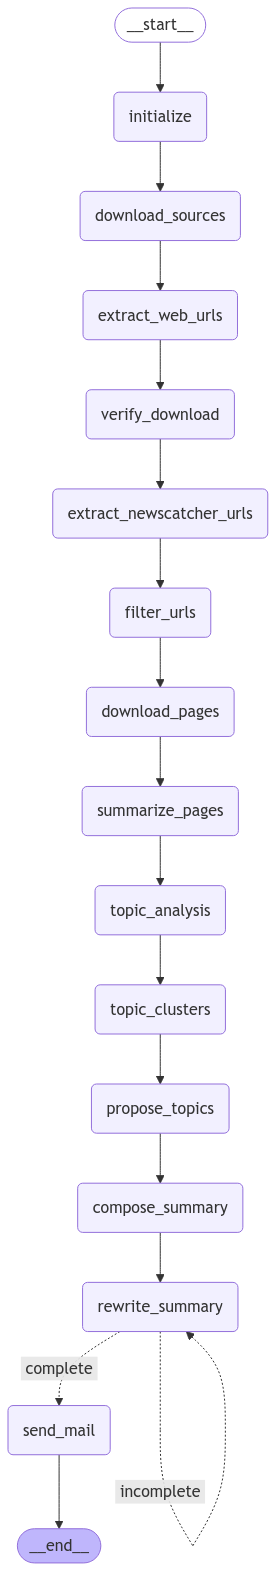

In [9]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-16 18:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [10]:
state = lg_agent.initialize(state)


2025-02-17 11:43:54,616 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-17 11:43:54,617 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-17 11:43:54,618 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-17 11:43:54,618 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-17 11:43:54,618 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-17 11:43:54,619 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-17 11:43:54,619 - AInewsbot - INFO - 

In [11]:
state = lg_agent.download_sources(state)


2025-02-17 11:43:56,268 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-02-17 11:43:56,270 - AInewsbot - INFO - Found 16 previously downloaded files
2025-02-17 11:43:56,272 - AInewsbot - INFO - htmldata/Reddit multiple subreddits (02_17_2025 11_07_14 AM).html
2025-02-17 11:43:56,272 - AInewsbot - INFO - htmldata/HackerNoon (02_17_2025 11_06_44 AM).html
2025-02-17 11:43:56,273 - AInewsbot - INFO - htmldata/Ars Technica (02_17_2025 11_06_32 AM).html
2025-02-17 11:43:56,274 - AInewsbot - INFO - htmldata/Hacker News Page 1 (02_17_2025 11_06_41 AM).html
2025-02-17 11:43:56,275 - AInewsbot - INFO - htmldata/Bloomberg Technology (02_17_2025 11_06_33 AM).html
2025-02-17 11:43:56,276 - AInewsbot - INFO - htmldata/The Verge AI (02_17_2025 11_07_07 AM).html
2025-02-17 11:43:56,276 - AInewsbot - INFO - htmldata/Techmeme (02_17_2025 11_06_55 AM).html
2025-02-17 11:43:56,277 - AInewsbot - INFO - htmldata/Hacker News Page 2 (02_17_2025 11_06_42 AM).html
2025-02-17 11:43

In [12]:
state = lg_agent.extract_web_urls(state)


2025-02-17 11:43:58,904 - AInewsbot - INFO - Parsing html files
2025-02-17 11:43:58,909 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (02_17_2025 11_06_32 AM).html
2025-02-17 11:43:58,971 - AInewsbot - INFO - parse_file - found 204 raw links
2025-02-17 11:43:58,974 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-02-17 11:43:58,974 - AInewsbot - INFO - 35 links found
2025-02-17 11:43:58,975 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (02_17_2025 11_06_33 AM).html
2025-02-17 11:43:58,993 - AInewsbot - INFO - parse_file - found 200 raw links
2025-02-17 11:43:58,996 - AInewsbot - INFO - parse_file - found 15 filtered links
2025-02-17 11:43:58,997 - AInewsbot - INFO - 15 links found
2025-02-17 11:43:58,997 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (02_17_2025 11_06_29 AM).html
2025-02-17 11:43:59,019 - AInewsbot - INFO - parse_file - found 207 raw links
2025-02-17 11:43:59,022 - AInewsbot - INFO - parse_file 

In [13]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,29
Bloomberg Tech,12
Business Insider,21
FT Tech,62
Feedly AI,37
Hacker News,30
Hacker News 2,21
HackerNoon,99
NYT Tech,19


number of missing sources 0


set()

In [14]:
state = lg_agent.verify_download(state)


2025-02-17 11:44:06,626 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [15]:
state = lg_agent.extract_newscatcher_urls(state)


2025-02-17 11:44:08,982 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher
2025-02-17 11:44:09,113 - AInewsbot - INFO - Newscatcher download failed


ERROR: API call failed.
{'status': 'error', 'error_code': 'LimitReached', 'message': 'Monthly API calls limit reached: 3000'}


In [16]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


2025-02-17 11:44:12,087 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-02-16 18:00'
2025-02-17 11:44:12,560 - AInewsbot - INFO - URLs in orig_df: 812
2025-02-17 11:44:12,563 - AInewsbot - INFO - Existing URLs in DB: 217396
2025-02-17 11:44:12,625 - AInewsbot - INFO - New URLs in df filtered by URL: 240
2025-02-17 11:44:12,751 - AInewsbot - INFO - Existing src+title: 24
2025-02-17 11:44:12,752 - AInewsbot - INFO - New URLs in df filtered by src+title: 216
2025-02-17 11:44:12,766 - AInewsbot - INFO - Found 216 unique new headlines
2025-02-17 11:44:12,769 - AInewsbot - INFO - Found 216 unique new headlines
2025-02-17 11:44:14,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:44:17,306 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:44:18,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 2

,id
src,
Ars Technica,1
Business Insider,1
FT Tech,2
Feedly AI,33
Hacker News,4
Hacker News 2,2
HackerNoon,7
Reddit,2
Techmeme,8


2025-02-17 11:44:29,025 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 90372
2025-02-17 11:44:29,026 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 90372
2025-02-17 11:44:29,026 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 90372
2025-02-17 11:44:29,026 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 90372
2025-02-17 11:44:45,334 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 11:44:45,334 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 11:44:45,334 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 11:44:45,334 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-17 11:44:45,335 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 11:44:45,335 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 11:44:45,336 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-17 11:44

In [17]:
state = lg_agent.download_pages(state)


2025-02-17 11:44:25,888 - AInewsbot - INFO - Queuing URLs for scraping


> /Users/drucev/projects/AInewsbot/AInewsbot_langgraph.py(783)fn_download_pages()
    781     pdb.set_trace()
    782     global BROWSERS
--> 783     if 'BROWSERS' not in globals() or len(BROWSERS) < NUM_BROWSERS:
    784         BROWSERS = asyncio.run(get_browsers(NUM_BROWSERS))
    785 

ipdb> c


2025-02-17 11:45:38,688 - AInewsbot - INFO - Processing page 0: https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/
2025-02-17 11:45:38,691 - AInewsbot - INFO - Processing page 1: https://www.bloomberg.com/news/newsletters/2025-02-16/apple-and-meta-are-set-to-battle-over-new-area-humanoid-robots-m77mwid3
2025-02-17 11:45:38,691 - AInewsbot - INFO - Processing page 2: https://techcrunch.com/2025/02/16/open-source-llms-hit-europes-digital-sovereignty-roadmap/
2025-02-17 11:45:38,692 - AInewsbot - INFO - Processing page 3: https://www.wsj.com/business/ai-agents-customer-service-b4dc99e5
2025-02-17 11:45:38,692 - AInewsbot - INFO - get_url(https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/) - starting get_url https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/
2025-02-17 11:45:38,694 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/newsletters/2025-02-16/apple-and-meta-are-set-to-battle-over-

2025-02-17 11:45:38,709 - AInewsbot - INFO - Processing page 18: https://www.chicagotribune.com/2025/02/17/deepseeks-ai/
2025-02-17 11:45:38,710 - AInewsbot - INFO - get_url(https://www.chicagotribune.com/2025/02/17/deepseeks-ai/) - starting get_url https://www.chicagotribune.com/2025/02/17/deepseeks-ai/
2025-02-17 11:45:38,710 - AInewsbot - INFO - Processing page 21: https://www.digitaltrends.com/mobile/gemini-live-could-soon-provide-on-the-go-subtitles-for-the-hearing-impaired/
2025-02-17 11:45:38,709 - AInewsbot - INFO - Processing page 19: https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations
2025-02-17 11:45:38,710 - AInewsbot - INFO - get_url(https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations) - starting get_url https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations
2025-02-17 11:45:38,710 - AInewsbot - 

2025-02-17 11:45:38,728 - AInewsbot - INFO - Processing page 38: https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt
2025-02-17 11:45:38,729 - AInewsbot - INFO - Processing page 39: https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization
2025-02-17 11:45:38,730 - AInewsbot - INFO - get_url(https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt) - starting get_url https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt
2025-02-17 11:45:38,730 - AInewsbot - INFO - Processing page 40: https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/
2025-02-17 11:45:38,730 - AInewsbot - INFO - get_url(https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization) - starting get_url https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization
2025-02-17 11:45:38,731 - A

2025-02-17 11:45:38,739 - AInewsbot - INFO - get_url(https://www.technologyreview.com/2025/02/17/1111978/the-download-ancient-dna-ai-artist/) - starting get_url https://www.technologyreview.com/2025/02/17/1111978/the-download-ancient-dna-ai-artist/
2025-02-17 11:45:38,740 - AInewsbot - INFO - get_url(https://www.computerweekly.com/feature/The-irresistible-marriage-of-AI-and-XR) - starting get_url https://www.computerweekly.com/feature/The-irresistible-marriage-of-AI-and-XR
2025-02-17 11:45:38,741 - AInewsbot - INFO - Processing page 61: https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19
2025-02-17 11:45:38,741 - AInewsbot - INFO - get_url(https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19) - starting get_url https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19
2025-02-17 11:45:38,742 - AInewsbot - INFO - Processing page 62: https://www.ruder.io/secret-word2vec/
2025-02-17 11:45:38,743 - AInewsbot - INFO - get_url(https://www.ruder.io/secret-word2vec

In [18]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


2025-02-17 11:46:07,907 - AInewsbot - INFO - Starting summarize
2025-02-17 11:46:07,986 - AInewsbot - INFO - fetch_all_summaries - Page title: 5 high-tech robots that are changing how we grow our food
Social card title: 5 high-tech robots that are changing how we grow our food
Social card description: Tech-savvy robots are revolutionizing the agricultural industry — from self-driving tractors to herbicide-spraying AI.

2025-02-17 11:46:08,290 - AInewsbot - INFO - fetch_all_summaries - Page title: Bloomberg - Are you a robot?

2025-02-17 11:46:08,308 - AInewsbot - INFO - fetch_all_summaries - Page title: Open source LLMs hit Europe's digital sovereignty roadmap | TechCrunch
Social card title: Open source LLMs hit Europe's digital sovereignty roadmap | TechCrunch
Social card description: Large language models (LLMs) landed on Europe's digital sovereignty agenda with a bang last week, as news emerged of a new program to develop a series of

2025-02-17 11:46:08,335 - AInewsbot - INFO - fet

2025-02-17 11:46:09,059 - AInewsbot - INFO - fetch_all_summaries - Page title: Gemini Live could soon provide on-the-go subtitles for the hearing impaired | Digital Trends
Social card title: Gemini Live could soon provide on-the-go subtitles for the hearing impaired
Social card description: Google’s Gemini Live may soon introduce a helpful feature that will allow more people to benefit from it.

2025-02-17 11:46:09,083 - AInewsbot - INFO - fetch_all_summaries - Page title: Generative AI is already being used in journalism – here’s how people feel about it
Social card title: Generative AI is already being used in journalism – here’s how people feel about it
Social card description: A new report on journalism in seven countries shows AI might have a place in the newsroom – but everyone should proceed with caution.

2025-02-17 11:46:09,106 - AInewsbot - INFO - fetch_all_summaries - Page title: Google Chrome introduces AI-powered update to Safe Browsing feature
Social card title: Google Ch

2025-02-17 11:46:09,724 - AInewsbot - INFO - fetch_all_summaries - Page title: Audacity ® | Introducing OpenVINO AI effects for Audacity

2025-02-17 11:46:09,739 - AInewsbot - INFO - fetch_all_summaries - Page title: Palantir Stakes Its Claim in the AI Arms Race - TipRanks.com
Social card title: Palantir Stakes Its Claim in the AI Arms Race - TipRanks.com
Social card description: Palantir Technologies ($PLTR) continues to defy expectations and even stir up the AI software space. It had a remarkable success in 2024, which set the stage for an...

2025-02-17 11:46:09,795 - AInewsbot - INFO - fetch_all_summaries - Page title: Nicolas Chagnet's Page

2025-02-17 11:46:10,395 - AInewsbot - INFO - fetch_all_summaries - Page title: Pluralistic: Business school professors trained an AI to judge workers’ personalities based on their faces (17 Feb 2025) – Pluralistic: Daily links from Cory Doctorow

2025-02-17 11:46:10,428 - AInewsbot - INFO - fetch_all_summaries - Page title: Medscape Registrati

2025-02-17 11:46:11,032 - AInewsbot - INFO - fetch_all_summaries - Page title: Zypher's speech model can clone your voice with 5s of audio • The Register
Social card title: Zypher's speech model can clone your voice with 5s of audio
Social card description: El Reg shows you how to run Zyphra's speech-replicating AI on your own box

2025-02-17 11:46:11,066 - AInewsbot - INFO - fetch_all_summaries - Page title: Trump wants to make changes to Biden's CHIPS act. Here’s what that could mean for AI growth and consumers | Fortune
Social card title: Trump wants to make changes to Biden's CHIPS act. Here’s what that could mean for AI growth and consumers
Social card description: Trump's threats to alter federal government contracts with chipmakers and slap new tariffs on the semiconductor industry may put new speed bumps in front of the tech industry.

2025-02-17 11:46:11,105 - AInewsbot - INFO - fetch_all_summaries - Page title: Tutorial: Semantic Clustering of User Messages with LLM Prompts |

2025-02-17 11:46:15,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:15,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:15,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:15,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:15,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:15,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:16,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:16,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:46:17,682 - httpx 

In [19]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))

- High-tech agricultural robots are revolutionizing farming, including AI-guided herbicide sprayers that can target weeds with precision, cutting chemical usage by up to 90% and reducing costs.
- Innovations such as autonomous electric tractors, UV-emitting fungus-busting robots, and AI-driven weed-zapping lasers are enhancing efficiency, sustainability, and productivity in crop management without relying on harmful chemicals.
- Ethical considerations around labor displacement are being raised as self-driving tractors and other autonomous technologies enable 24/7 operation and reduce the need for human labor.

In [20]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# series of structured AI prompts to ask if standard topics are covered 
state = lg_agent.topic_analysis(state)


2025-02-17 11:47:11,549 - AInewsbot - INFO - start free-form topic extraction
2025-02-17 11:47:26,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:26,829 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:26,843 - AInewsbot - INFO - 66 free-form topics extracted
2025-02-17 11:47:26,844 - AInewsbot - INFO - Starting assigned topic extraction
2025-02-17 11:47:26,845 - AInewsbot - INFO - Canonical topic hollywood
2025-02-17 11:47:26,846 - AInewsbot - INFO - Canonical topic products
2025-02-17 11:47:26,846 - AInewsbot - INFO - Canonical topic code assistants
2025-02-17 11:47:26,847 - AInewsbot - INFO - Canonical topic journalism
2025-02-17 11:47:26,847 - AInewsbot - INFO - Canonical topic cryptocurrency
2025-02-17 11:47:26,848 - AInewsbot - INFO - Canonical topic ethics
2025-02-17 11:47:26,848 - AInewsbot - INFO - Canonical topic brain-computer interfaces
2025

2025-02-17 11:47:26,872 - AInewsbot - INFO - Canonical topic finance
2025-02-17 11:47:26,873 - AInewsbot - INFO - Canonical topic consciousness
2025-02-17 11:47:26,873 - AInewsbot - INFO - Canonical topic the new york times
2025-02-17 11:47:26,874 - AInewsbot - INFO - Canonical topic infrastructure
2025-02-17 11:47:26,890 - AInewsbot - INFO - Canonical topic misinformation
2025-02-17 11:47:26,891 - AInewsbot - INFO - Canonical topic singularity
2025-02-17 11:47:26,891 - AInewsbot - INFO - Canonical topic uk
2025-02-17 11:47:26,892 - AInewsbot - INFO - Canonical topic music
2025-02-17 11:47:26,892 - AInewsbot - INFO - Canonical topic semiconductor chips
2025-02-17 11:47:26,892 - AInewsbot - INFO - Canonical topic supply chain optimization
2025-02-17 11:47:26,892 - AInewsbot - INFO - Canonical topic stocks
2025-02-17 11:47:26,893 - AInewsbot - INFO - Canonical topic deepfakes
2025-02-17 11:47:26,893 - AInewsbot - INFO - Canonical topic gen ai
2025-02-17 11:47:26,893 - AInewsbot - INFO - 

2025-02-17 11:47:31,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:31,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:31,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:31,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:31,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:32,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:32,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:32,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:32,054 - httpx 

2025-02-17 11:47:33,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:33,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:33,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:33,992 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:34,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:34,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:34,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:34,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:34,242 - httpx 

2025-02-17 11:47:36,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:47:36,889 - httpx 

In [21]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].title_topic_str))

5 high-tech robots that are changing how we grow our food (Topics: Agricultural Technology, Agriculture, AI Tools, Automation, Autonomous Vehicles, Bias And Fairness, Climate, Data-Driven Methods, Economics, Ethics, Food & Drink, Hardware, Inequality, Job Automation, Jobs & Careers, Labor Displacement, Labor Market, Machine Learning, Products, Robotics, Robots, Science, Sustainability)

In [22]:
state = lg_agent.topic_clusters(state)


2025-02-17 11:48:03,756 - AInewsbot - INFO - Fetching embeddings for 66 headlines
2025-02-17 11:48:08,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-17 11:48:08,491 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2025-02-17 11:48:08,506 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-02-17 11:48:10,197 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-17 11:48:11,596 - AInewsbot - INFO - Cluster with DBSCAN
2025-02-17 11:48:11,729 - AInewsbot - INFO - Found 0 clusters
2025-02-17 11:48:11,872 - AInewsbot - INFO - Sending bullet points email
2025-02-17 11:48:13,288 - AInewsbot - INFO - []


In [23]:
state = lg_agent.propose_topics(state)


2025-02-17 11:48:24,342 - AInewsbot - INFO - Proposing categories using o3-mini
2025-02-17 11:48:24,346 - AInewsbot - INFO - Initial cluster topics: 

2025-02-17 11:48:31,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:48:39,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:48:39,904 - AInewsbot - INFO - Added cluster topics using o3-mini: 
DeepSeek Privacy Violations
Palantir AI & Stock Surge
Conscious AI Pursuit by Nirvanic
Match Group AI for Safer Dating
DeepSeek Fuels Chinese Tech Rally
Deepfakes and Misinformation Risks
Mistral’s Fast AI Assistant
AI Models Optimize Power Grids
AI Tools for Cover Letter Writing
AI Reshapes Future Labor Market
AI Transforms Typography Design
ChromoGen Predicts 3D Genome Folding
No-Code Software via AI Collaboration
HiBob Integrates AI Financial Tools
Junior Developers Over-Rely on AI
AI Accelerates Antibiotic Discovery

In [24]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


2025-02-17 11:49:15,505 - AInewsbot - INFO - Composing summary using o3-mini
2025-02-17 11:54:29,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-17 11:54:29,228 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# DeepSeek Dilemmas: Privacy Panics & Chinese Charge
- South Korea's data protection authority suspends new downloads of DeepSeek due to partial non-compliance with local data protection laws, even as its web service remains available – [Reuters](https://www.reuters.com/technology/south-koreas-data-protection-authority-suspends-local-service-deepseek-2025-02-17/).
- Chinese tech stocks are rallying as DeepSeek’s advanced AI integration boosts valuations at giants like Tencent and Alibaba – [Business Insider Markets](https://markets.businessinsider.com/news/stocks/goldman-sachs-deepseek-china-ai-tech-stock-rally-different-tencent-2025-2).
- Tencent’s Weixin app is testing DeepSeek-powered search while Baidu plans full integration with its Ernie LLM, intensifying China’s AI competition – [Reuters](https://www.reuters.com/technology/artificial-intelligence/tencents-messaging-app-weixin-launches-beta-testing-with-deepseek-2025-02-16/).
- Skyworth integrates DeepSeek into its new G7F Pro smart TV, enabling local dialect recognition and multimedia content generation – [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinese-ai-model-deepseek-is-being-integrated-into-smart-tvs-skyworth-g7f-pro-understands-local-dialects-and-generates-multimedia-content).
- In South Korea, downloads of DeepSeek’s AI apps are paused over privacy concerns, with officials urging users to avoid sharing personal information – [Chicago Tribune](https://www.chicagotribune.com/2025/02/17/deepseeks-ai/).
- South Korea bans new downloads of DeepSeek from app stores pending improved data protection measures amid global scrutiny – [BBC](https://www.bbc.com/news/articles/clyzym0vn8go).

# Corporate AI Power Plays
- Palantir’s stock surged over 400% in 2024, driven by its focus on leading the AI arms race and reinforcing U.S. national security – [TipRanks](https://www.tipranks.com/news/palantir-stakes-its-claim-in-the-ai-arms-race).
- Former President Trump proposes changes to the CHIPS Act that could raise semiconductor tariffs and hamper domestic AI development – [Fortune](https://fortune.com/2025/02/17/trump-changes-biden-chips-act-ai-growth-consumers/).
- Replit, in partnership with Anthropic and Google Cloud, empowers Zillow employees to build production software without traditional coding expertise – [VentureBeat](https://venturebeat.com/ai/replit-and-anthropics-ai-just-helped-zillow-build-production-software-without-a-single-engineer/).
- HiBob acquires fintech Mosaic to integrate AI-driven financial planning into its HR platform, enhancing real-time workforce insights – [FinTech Futures](https://www.fintechfutures.com/2025/02/hibob-acquires-us-fintech-mosaic-to-integrate-ai-powered-financial-management-into-hr-platform/).
- Elon Musk’s xAI is gearing up to launch Grok 3, touted as the "smartest AI on Earth" and trained on synthetic data for improved reasoning – [Ripples Nigeria](https://www.ripplesnigeria.com/elon-musk-owned-xai-to-release-latest-chatbot-grok-3-tagged-smartest-ai-on-earth/).
- Dream, an AI firm founded by former Austrian Chancellor Sebastian Kurz, has reached unicorn status with its cyber defense solutions – [Euronews](https://www.euronews.com/business/2025/02/17/ai-firm-started-by-austrias-former-pm-sebastian-kurz-hits-unicorn-status).
- Mistral AI debuts “Le Chat,” an AI assistant powered by Cerebras technology and a 123B-parameter model that delivers responses 10× faster than ChatGPT – [Hacker Noon](https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt).
- Mistral unveils “Mistral Saba,” a 24-billion-parameter model tailored for Arabic and South Indian language applications, targeting regional markets – [TechCrunch](https://techcrunch.com/2025/02/17/mistral-releases-regional-model-focused-on-arabic-language-and-culture/).

# Future of Work: Code, Career, and Creativity
- Generative AI is automating routine tasks across sectors, though complex and high-stakes roles remain less susceptible to automation – [Financial Times](https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19).
- ChatGPT envisions a future labor market dominated by decentralized, project-based work where continuous learning and personal branding are key – [Hacker Noon](https://hackernoon.com/i-asked-chatgpt-what-the-future-of-labor-market-holdsheres-what-it-said).
- Junior developers increasingly rely on AI tools like Copilot and Claude for coding, risking a shallow foundational understanding of software development – [nmn.gl](https://nmn.gl/blog/ai-and-learning).
- The Impact of Tech 2025 report notes that 85% of businesses now use AI, driving productivity gains and sparking interest in a four-day work week – [Tech.co](https://tech.co/news/impact-of-tech-report-2025).
- Job seekers are encouraged to master AI-driven hiring tools and engage proactively with Applicant Tracking Systems to secure career success – [San Diego Union Tribune](https://www.sandiegouniontribune.com/2025/02/17/how-to-unlock-the-secrets-of-ai-and-get-hired/).
- Designers face an evolving landscape as AI demands new accessibility features and prompts a reevaluation of their creative roles – [UX Design](https://uxdesign.cc/ai-needs-designers-accessibility-affordances-i-dont-know-where-i-fit-anymore-1caf45f016d5).
- AI tools like ChatGPT are streamlining the creation of personalized cover letters, though applicants must review and refine the outputs for a professional touch – [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-write-a-cover-letter/).

# Science & Sustain: Genes, Grids, and Green Fields
- Ancient DNA technology is mapping genetic histories and inspiring live art collaborations with nonbinary artist Sougwen Chung – [Technology Review](https://www.technologyreview.com/2025/02/17/1111978/the-download-ancient-dna-ai-artist/).
- A comprehensive study of 44 power flow linearization methods underscores data-driven approaches to optimizing power grid performance – [Hacker Noon](https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization).
- MIT's ChromoGen leverages AI to predict thousands of 3D chromatin structures in minutes, advancing our understanding of gene expression – [Chemistry World](https://www.chemistryworld.com/news/ai-inspired-by-alphafold-can-predict-chromatin-structures-found-in-chromosomes/4020964.article).
- The free ESKAPE Model accelerates antibiotic discovery by screening molecular structures against drug-resistant pathogens, offering a breakthrough in global health – [Medscape](https://www.medscape.com/viewarticle/publicly-accessible-ai-tool-could-speed-antibiotic-discovery-2025a100041w).
- AI-enhanced ultrasound software by BrightHeart significantly boosts sensitivity and specificity in detecting congenital heart defects during pregnancy – [Healio](https://www.healio.com/news/womens-health-ob-gyn/20250217/ai-software-improves-ultrasound-detection-of-congenital-heart-defects-in-pregnancy).
- Autonomous agricultural robots, from precise herbicide sprayers to electric tractors, are revolutionizing farming efficiency and sustainability – [The Cooldown](https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/).
- A groundbreaking Chinese cancer drug nearly doubles progression-free survival in non-small-cell lung cancer patients, marking a significant pharmaceutical advancement – [The Economist](https://www.economist.com/business/2025/02/16/its-not-just-ai-chinas-medicines-are-surprising-the-world-too).

# Journalism & AI: The New Byline
- The New York Times adopts its internal AI tool “Echo” to enhance tasks like summarizing articles and optimizing SEO, marking a new era in journalism – [ReadWrite](https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/).
- In a bold move, NYT greenlights several AI tools—including GitHub Copilot and Google’s Vertex AI—while enforcing guidelines to mitigate copyright risks – [Semafor](https://www.semafor.com/article/02/16/2025/new-york-times-goes-all-in-on-internal-ai-tools).
- A multi-country report uncovers mixed feelings towards generative AI in journalism, with concerns about transparency and potential biases in content creation – [The Conversation](https://theconversation.com/generative-ai-is-already-being-used-in-journalism-heres-how-people-feel-about-it-247232).

# Digital Discourse & AI: Shaping Social Spaces
- The rise of deepfakes is fueling convincing misinformation, with AI-generated content posing risks to individuals and institutions – [TapInto](https://www.tapinto.net/towns/basking-ridge/sections/other-nj-news/articles/deepfakes-and-ai-misinformation-can-you-trust-what-you-see).
- Match Group leverages AI to detect and mitigate abusive messages on its dating apps, significantly reducing off-color communications – [Twitter](https://t.co/75gCvrMvG6).
- Reddit moderators are battling the surge of AI-generated content and calling for enhanced tools to preserve discussion quality – [Ars Technica](https://arstechnica.com/gadgets/2025/02/reddit-mods-are-fighting-to-keep-ai-slop-off-subreddits-they-could-use-help/).
- Dating experts caution against overusing AI in personal interactions, warning that excessive reliance may hinder genuine connection – [Mashable](https://me.mashable.com/tech/52769/should-you-be-using-ai-in-your-dating-life).
- AI agents are increasingly adept at decoding human personalities to influence behaviors, raising calls for regulatory transparency – [VentureBeat](https://venturebeat.com/ai/like-it-or-not-ai-is-learning-how-to-influence-you/).
- An AI experiment resurrects historical figures with altered, youthful looks, sparking playful online debates – [Reddit](https://v.redd.it/mnk0jb9xcnje1).
- AI-powered “taste atlases” analyze thematic preferences to curate personalized recommendations for movies, music, and books – [Fast Company](https://www.fastcompany.com/91279431/how-to-use-ai-to-find-new-movies-music-and-books).
- Facing concerns over misinformation and algorithmic shifts, the Danish National Police are planning to exit X in favor of a proprietary platform – [The Local](https://www.thelocal.dk/20250215/why-the-danish-police-are-preparing-to-leave-x).
- Critics dismiss the “Photo Big 5” AI, designed to assess personalities from photos, as modern-day pseudoscience akin to phrenology – [Pluralistic](https://pluralistic.net/2025/02/17/caliper-ai/).

# Developer & Infrastructure Innovations
- Word2vec’s performance is driven more by hyperparameter tuning than by the algorithm itself, challenging prevailing assumptions in natural language processing – [www.ruder.io](https://www.ruder.io/secret-word2vec/).
- Bag of Words offers an AI-powered platform for building smart data applications through natural language queries and seamless data integration – [GitHub](https://github.com/bagofwords1/bagofwords).
- A tutorial on semantic clustering demonstrates how LLM prompts can efficiently group user messages and uncover discussion patterns on platforms like Discord – [Towards Data Science](https://towardsdatascience.com/tutorial-semantic-clustering-of-user-messages-with-llm-prompts/).
- Physics-informed neural networks provide a mesh-free solution to differential equations, offering high accuracy for complex scientific problems – [nchagnet.pages.dev](https://nchagnet.pages.dev/blog/physics-informed-neural-networks/).
- The Ducho framework unifies feature extraction from audio, visual, and textual data to power advanced recommendation systems – [Hacker Noon](https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations).
- SoluAI leverages a decentralized blockchain-powered GPU network to reduce AI training costs by up to 70%, fostering a more efficient computing ecosystem – [Hacker Noon](https://hackernoon.com/soluai-decentralized-ai-computing-on-blockchain-powered-by-gpu-networks).

# Security & Cyber Shields
- Google Chrome's new AI-powered Safe Browsing update delivers real-time protection against malicious sites and downloads, enhancing user security – [Tech Monitor](https://www.techmonitor.ai/technology/cybersecurity/google-chrome-ai-powered-update-safe-browsing-feature).
- Zyphra's Zonos text-to-speech model can clone voices using as little as five seconds of audio, though it raises ethical concerns over potential misuse – [The Register](https://www.theregister.com/2025/02/16/ai_voice_clone/).

# AI & XR: Reality Reimagined
- Gemini Live is beta-testing real-time captions for AI-generated responses, enhancing accessibility for users in noisy environments and for the hearing impaired – [Digital Trends](https://www.digitaltrends.com/mobile/gemini-live-could-soon-provide-on-the-go-subtitles-for-the-hearing-impaired/).
- The Step-Video-T2V model, with 30 billion parameters, pioneers text-to-video generation by integrating bilingual encoders and advanced noise reduction techniques – [arXiv](https://arxiv.org/abs/2502.10248).
- The fusion of AI and XR technologies is creating immersive digital twins and responsive environments that are transforming industries from automotive to aerospace – [Computer Weekly](https://www.computerweekly.com/feature/The-irresistible-marriage-of-AI-and-XR).

# Governing the Future: Global AI Talks
- At the Paris AI Summit, global leaders called for binding regulatory frameworks for AI, drawing parallels to the challenges faced in climate change accords – [TechPolicy Press](https://www.techpolicy.press/after-paris-what-future-ai-summits-must-learn-from-climate-change-and-the-cop-series/).

# Creative Convergence: AI in Art & Audio
- Intel’s OpenVINO AI tools for Audacity enable local noise suppression, transcription, and music generation plugins, empowering creative audio editing – [Audacity](https://www.audacityteam.org/blog/openvino-ai-effects/).

# Beyond Binary: The Consciousness Conundrum
- Canadian startup Nirvanic is exploring the creation of a conscious AI using quantum computing, sparking fierce debates over whether consciousness can emerge from complex algorithms – [Hacker Noon](https://hackernoon.com/is-it-possible-to-create-a-conscious-artificial-intelligence-this-canadian-startup-thinks-so).

2025-02-17 11:54:29,243 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-17 11:56:09,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Frontlines: DeepSeek Drama, Corporate Conquests & Work Rewired

## DeepSeek Surge & Scrutiny
- South Korea suspends new DeepSeek downloads and warns against data sharing pending improved protections – [Reuters](https://www.reuters.com/technology/south-koreas-data-protection-authority-suspends-local-service-deepseek-2025-02-17/), [Chicago Tribune](https://www.chicagotribune.com/2025/02/17/deepseeks-ai/), [BBC](https://www.bbc.com/news/articles/clyzym0vn8go).
- Chinese tech giants integrate DeepSeek for enhanced AI features and market rally, with Tencent testing search, Baidu planning full Ernie LLM integration, and Skyworth using it in smart TVs – [Business Insider Markets](https://markets.businessinsider.com/news/stocks/goldman-sachs-deepseek-china-ai-tech-stock-rally-different-tencent-2025-2), [Reuters](https://www.reuters.com/technology/artificial-intelligence/tencents-messaging-app-weixin-launches-beta-testing-with-deepseek-2025-02-16/), [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinese-ai-model-deepseek-is-being-integrated-into-smart-tvs-skyworth-g7f-pro-understands-local-dialects-and-generates-multimedia-content).

## Corporate AI Conquests
- Palantir stock surges over 400% in 2024 on its AI and national security focus – [TipRanks](https://www.tipranks.com/news/palantir-stakes-its-claim-in-the-ai-arms-race).
- Former President Trump proposes CHIPS Act amendments that may raise semiconductor tariffs – [Fortune](https://fortune.com/2025/02/17/trump-changes-biden-chips-act-ai-growth-consumers/).
- Replit partners with Anthropic and Google Cloud to enable Zillow employees to build production software without traditional coding – [VentureBeat](https://venturebeat.com/ai/replit-and-anthropics-ai-just-helped-zillow-build-production-software-without-a-single-engineer/).
- HiBob acquires Mosaic to add AI-driven financial planning to its HR platform – [FinTech Futures](https://www.fintechfutures.com/2025/02/hibob-acquires-us-fintech-mosaic-to-integrate-ai-powered-financial-management-into-hr-platform/).
- Elon Musk’s xAI plans launch of Grok 3, trained on synthetic data and touted as the "smartest AI on Earth" – [Ripples Nigeria](https://www.ripplesnigeria.com/elon-musk-owned-xai-to-release-latest-chatbot-grok-3-tagged-smartest-ai-on-earth/).
- Dream, founded by former Austrian Chancellor Sebastian Kurz, reaches unicorn status with its cyber defense solutions – [Euronews](https://www.euronews.com/business/2025/02/17/ai-firm-started-by-austrias-former-pm-sebastian-kurz-hits-unicorn-status).
- Mistral AI launches two new models: “Le Chat” (123B parameters, 10× faster responses) and “Mistral Saba” (24B parameters for Arabic and South Indian languages) – [Hacker Noon](https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt), [TechCrunch](https://techcrunch.com/2025/02/17/mistral-releases-regional-model-focused-on-arabic-language-and-culture/).

## Work Rewired
- Generative AI automates routine tasks across sectors, though complex roles remain less impacted – [Financial Times](https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19).
- ChatGPT envisions a decentralized, project-based labor market that emphasizes continuous learning and personal branding – [Hacker Noon](https://hackernoon.com/i-asked-chatgpt-what-the-future-of-labor-market-holdsheres-what-it-said).
- Junior developers increasingly rely on AI coding tools, risking weaker foundational skills – [nmn.gl](https://nmn.gl/blog/ai-and-learning).
- 85% of businesses now use AI to boost productivity and explore a four-day work week – [Tech.co](https://tech.co/news/impact-of-tech-report-2025).
- Job seekers are advised to master AI-driven hiring tools and optimize Applicant Tracking Systems – [San Diego Union Tribune](https://www.sandiegouniontribune.com/2025/02/17/how-to-unlock-the-secrets-of-ai-and-get-hired/).
- Designers adapt to AI-driven demands for new accessibility features and evolving creative roles – [UX Design](https://uxdesign.cc/ai-needs-designers-accessibility-affordances-i-dont-know-where-i-fit-anymore-1caf45f016d5).
- AI tools streamline the creation of personalized cover letters, though applicants should review outputs for professionalism – [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-write-a-cover-letter/).

## Smart Science & Sustainable Solutions
- Ancient DNA technology maps genetic histories and sparks live art collaborations with Sougwen Chung – [Technology Review](https://www.technologyreview.com/2025/02/17/1111978/the-download-ancient-dna-ai-artist/).
- A study of 44 power flow linearization methods offers data-driven approaches to optimize power grids – [Hacker Noon](https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization).
- MIT's ChromoGen uses AI to predict thousands of 3D chromatin structures in minutes, enhancing gene expression insights – [Chemistry World](https://www.chemistryworld.com/news/ai-inspired-by-alphafold-can-predict-chromatin-structures-found-in-chromosomes/4020964.article).
- The free ESKAPE Model accelerates antibiotic discovery by screening molecules against drug-resistant pathogens – [Medscape](https://www.medscape.com/viewarticle/publicly-accessible-ai-tool-could-speed-antibiotic-discovery-2025a100041w).
- AI-enhanced ultrasound software by BrightHeart improves detection of congenital heart defects during pregnancy – [Healio](https://www.healio.com/news/womens-health-ob-gyn/20250217/ai-software-improves-ultrasound-detection-of-congenital-heart-defects-in-pregnancy).
- Autonomous agricultural robots, from precision herbicide sprayers to electric tractors, boost farming efficiency and sustainability – [The Cooldown](https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/).
- A Chinese cancer drug nearly doubles progression-free survival in non-small-cell lung cancer patients – [The Economist](https://www.economist.com/business/2025/02/16/its-not-just-ai-chinas-medicines-are-surprising-the-world-too).

## Byline Bots
- The New York Times integrates its AI tool “Echo” for article summarization and SEO, and adds tools like GitHub Copilot and Google Vertex AI under copyright safeguards – [ReadWrite](https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/), [Semafor](https://www.semafor.com/article/02/16/2025/new-york-times-goes-all-in-on-internal-ai-tools).
- A multi-country report reveals mixed attitudes toward generative AI in journalism, with transparency and bias concerns – [The Conversation](https://theconversation.com/generative-ai-is-already-being-used-in-journalism-heres-how-people-feel-about-it-247232).

## Social Signals
- AI-generated deepfakes contribute to widespread misinformation – [TapInto](https://www.tapinto.net/towns/basking-ridge/sections/other-nj-news/articles/deepfakes-and-ai-misinformation-can-you-trust-what-you-see).
- Match Group uses AI to detect and reduce abusive messages on its dating apps – [Twitter](https://t.co/75gCvrMvG6).
- Reddit moderators seek enhanced tools to combat a surge in AI-generated content – [Ars Technica](https://arstechnica.com/gadgets/2025/02/reddit-mods-are-fighting-to-keep-ai-slop-off-subreddits-they-could-use-help/).
- Dating experts warn that overreliance on AI in personal interactions may impede genuine connections – [Mashable](https://me.mashable.com/tech/52769/should-you-be-using-ai-in-your-dating-life).
- AI agents decode human personality traits to influence behavior, prompting calls for regulatory transparency – [VentureBeat](https://venturebeat.com/ai/like-it-or-not-ai-is-learning-how-to-influence-you/).
- An AI experiment reimagines historical figures with youthful appearances, sparking online debate – [Reddit](https://v.redd.it/mnk0jb9xcnje1).
- AI-powered “taste atlases” generate personalized media recommendations based on thematic preferences – [Fast Company](https://www.fastcompany.com/91279431/how-to-use-ai-to-find-new-movies-music-and-books).
- Danish police plan to leave X amid concerns over misinformation and algorithmic shifts – [The Local](https://www.thelocal.dk/20250215/why-the-danish-police-are-preparing-to-leave-x).
- Critics label the “Photo Big 5” AI for personality assessments as pseudoscience akin to phrenology – [Pluralistic](https://pluralistic.net/2025/02/17/caliper-ai/).

## Dev & Infra Ingenuity
- Word2vec performance hinges on hyperparameter tuning more than the algorithm itself – [ruder.io](https://www.ruder.io/secret-word2vec/).
- Bag of Words enables the creation of smart data applications via natural language queries – [GitHub](https://github.com/bagofwords1/bagofwords).
- A tutorial demonstrates semantic clustering with LLM prompts to group user messages efficiently – [Towards Data Science](https://towardsdatascience.com/tutorial-semantic-clustering-of-user-messages-with-llm-prompts/).
- Physics-informed neural networks offer mesh-free solutions for differential equations with high accuracy – [nchagnet.pages.dev](https://nchagnet.pages.dev/blog/physics-informed-neural-networks/).
- The Ducho framework unifies feature extraction from audio, visual, and textual data to power recommendation systems – [Hacker Noon](https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations).
- SoluAI utilizes a blockchain-powered GPU network to reduce AI training costs by up to 70% – [Hacker Noon](https://hackernoon.com/soluai-decentralized-ai-computing-on-blockchain-powered-by-gpu-networks).

## Cyber Shields
- Google Chrome introduces an AI-powered Safe Browsing update offering real-time protection against malicious sites – [Tech Monitor](https://www.techmonitor.ai/technology/cybersecurity/google-chrome-ai-powered-update-safe-browsing-feature).
- Zyphra's Zonos text-to-speech model can clone voices from as little as five seconds of audio, raising ethical concerns – [The Register](https://www.theregister.com/2025/02/16/ai_voice_clone/).

## XR & AI Fusion
- Gemini Live beta-tests AI-generated, real-time captions to improve accessibility – [Digital Trends](https://www.digitaltrends.com/mobile/gemini-live-could-soon-provide-on-the-go-subtitles-for-the-hearing-impaired/).
- The Step-Video-T2V model (30B parameters) pioneers bilingual text-to-video generation with advanced noise reduction – [arXiv](https://arxiv.org/abs/2502.10248).
- The fusion of AI and XR creates immersive digital twins and responsive environments across industries – [Computer Weekly](https://www.computerweekly.com/feature/The-irresistible-marriage-of-AI-and-XR).

## Global AI Governance
- At the Paris AI Summit, global leaders call for binding regulatory frameworks for AI, akin to climate change accords – [TechPolicy Press](https://www.techpolicy.press/after-paris-what-future-ai-summits-must-learn-from-climate-change-and-the-cop-series/).

## Creative AI Beats
- Intel’s OpenVINO AI tools integrate with Audacity to provide noise suppression, transcription, and music generation features – [Audacity](https://www.audacityteam.org/blog/openvino-ai-effects/).

## Conscious Code
- Nirvanic, a Canadian startup, explores creating a conscious AI via quantum computing, sparking debate over algorithmic emergence of consciousness – [Hacker Noon](https://hackernoon.com/is-it-possible-to-create-a-conscious-artificial-intelligence-this-canadian-startup-thinks-so).

2025-02-17 11:56:09,536 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-17 11:58:10,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Ascendant: DeepTech, Corporate Clout & Future Work

## DeepSeek Disruptions
- South Korea suspends new DeepSeek downloads and warns against data sharing pending improved protections – [Reuters](https://www.reuters.com/technology/south-koreas-data-protection-authority-suspends-local-service-deepseek-2025-02-17/), [Chicago Tribune](https://www.chicagotribune.com/2025/02/17/deepseeks-ai/), [BBC](https://www.bbc.com/news/articles/clyzym0vn8go).
- Chinese tech giants integrate DeepSeek in products, with Tencent beta-testing search, Baidu planning full Ernie LLM integration, and Skyworth embedding it in smart TVs – [Business Insider Markets](https://markets.businessinsider.com/news/stocks/goldman-sachs-deepseek-china-ai-tech-stock-rally-different-tencent-2025-2), [Reuters](https://www.reuters.com/technology/artificial-intelligence/tencents-messaging-app-weixin-launches-beta-testing-with-deepseek-2025-02-16/), [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinese-ai-model-deepseek-is-being-integrated-into-smart-tvs-skyworth-g7f-pro-understands-local-dialects-and-generates-multimedia-content).

## Corporate Clout
- Palantir stock surges over 400% in 2024, driven by AI and national security focus – [TipRanks](https://www.tipranks.com/news/palantir-stakes-its-claim-in-the-ai-arms-race).
- Former President Trump proposes CHIPS Act amendments that may raise semiconductor tariffs – [Fortune](https://fortune.com/2025/02/17/trump-changes-biden-chips-act-ai-growth-consumers/).
- Replit partners with Anthropic and Google Cloud to enable Zillow to build production software without traditional coding – [VentureBeat](https://venturebeat.com/ai/replit-and-anthropics-ai-just-helped-zillow-build-production-software-without-a-single-engineer/).
- HiBob acquires Mosaic to integrate AI-driven financial planning into its HR platform – [FinTech Futures](https://www.fintechfutures.com/2025/02/hibob-acquires-us-fintech-mosaic-to-integrate-ai-powered-financial-management-into-hr-platform/).
- Elon Musk’s xAI plans the launch of Grok 3, trained on synthetic data and touted as the "smartest AI on Earth" – [Ripples Nigeria](https://www.ripplesnigeria.com/elon-musk-owned-xai-to-release-latest-chatbot-grok-3-tagged-smartest-ai-on-earth/).
- Dream, founded by former Austrian Chancellor Sebastian Kurz, reaches unicorn status with its cyber defense solutions – [Euronews](https://www.euronews.com/business/2025/02/17/ai-firm-started-by-austrias-former-pm-sebastian-kurz-hits-unicorn-status).
- Mistral AI launches two models: “Le Chat” (123B parameters, 10× faster) and “Mistral Saba” (24B parameters for Arabic and South Indian languages) – [Hacker Noon](https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt), [TechCrunch](https://techcrunch.com/2025/02/17/mistral-releases-regional-model-focused-on-arabic-language-and-culture/).

## Work Reboot
- Generative AI automates routine tasks across sectors, though complex roles remain less impacted – [Financial Times](https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19).
- ChatGPT envisions a decentralized, project-based labor market emphasizing continuous learning – [Hacker Noon](https://hackernoon.com/i-asked-chatgpt-what-the-future-of-labor-market-holdsheres-what-it-said).
- Junior developers increasingly rely on AI coding tools, potentially weakening foundational skills – [nmn.gl](https://nmn.gl/blog/ai-and-learning).
- 85% of businesses use AI to boost productivity and explore a four-day work week – [Tech.co](https://tech.co/news/impact-of-tech-report-2025).
- Job seekers are advised to master AI-driven hiring tools and optimize Applicant Tracking Systems – [San Diego Union Tribune](https://www.sandiegouniontribune.com/2025/02/17/how-to-unlock-the-secrets-of-ai-and-get-hired/).
- Designers adapt to AI-driven demands for new accessibility features and evolving creative roles – [UX Design](https://uxdesign.cc/ai-needs-designers-accessibility-affordances-i-dont-know-where-i-fit-anymore-1caf45f016d5).
- AI tools streamline personalized cover letter creation, though outputs require review for professionalism – [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-write-a-cover-letter/).

## Science & Sustainability
- Ancient DNA tech maps genetic histories and sparks live art collaborations with Sougwen Chung – [Technology Review](https://www.technologyreview.com/2025/02/17/1111978/the-download-ancient-dna-ai-artist/).
- A study evaluates 44 power flow linearization methods to optimize power grids – [Hacker Noon](https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization).
- MIT's ChromoGen predicts thousands of 3D chromatin structures in minutes, enhancing gene expression insights – [Chemistry World](https://www.chemistryworld.com/news/ai-inspired-by-alphafold-can-predict-chromatin-structures-found-in-chromosomes/4020964.article).
- The free ESKAPE Model accelerates antibiotic discovery by screening molecules against drug-resistant pathogens – [Medscape](https://www.medscape.com/viewarticle/publicly-accessible-ai-tool-could-speed-antibiotic-discovery-2025a100041w).
- BrightHeart's AI-enhanced ultrasound software improves detection of congenital heart defects during pregnancy – [Healio](https://www.healio.com/news/womens-health-ob-gyn/20250217/ai-software-improves-ultrasound-detection-of-congenital-heart-defects-in-pregnancy).
- Autonomous agricultural robots boost farming efficiency and sustainability – [The Cooldown](https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/).
- A Chinese cancer drug nearly doubles progression-free survival in non-small-cell lung cancer patients – [The Economist](https://www.economist.com/business/2025/02/16/its-not-just-ai-chinas-medicines-are-surprising-the-world-too).

## Neural News
- Newsrooms deploy AI tools: The New York Times integrates “Echo”, GitHub Copilot, and Google Vertex AI, while a multi-country report reveals mixed attitudes toward generative AI in journalism – [ReadWrite](https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/), [Semafor](https://www.semafor.com/article/02/16/2025/new-york-times-goes-all-in-on-internal-ai-tools), [The Conversation](https://theconversation.com/generative-ai-is-already-being-used-in-journalism-heres-how-people-feel-about-it-247232).

## Social Stream
- AI-generated deepfakes fuel misinformation concerns – [TapInto](https://www.tapinto.net/towns/basking-ridge/sections/other-nj-news/articles/deepfakes-and-ai-misinformation-can-you-trust-what-you-see).
- Match Group uses AI to curb abusive messages on dating apps; experts warn excessive AI use may impede genuine connections – [Twitter](https://t.co/75gCvrMvG6), [Mashable](https://me.mashable.com/tech/52769/should-you-be-using-ai-in-your-dating-life).
- Reddit moderators seek advanced tools to manage surges in AI-generated content – [Ars Technica](https://arstechnica.com/gadgets/2025/02/reddit-mods-are-fighting-to-keep-ai-slop-off-subreddits-they-could-use-help/).
- AI agents analyze personality traits to influence behavior, prompting regulatory calls – [VentureBeat](https://venturebeat.com/ai/like-it-or-not-ai-is-learning-how-to-influence-you/).
- An AI experiment digitally rejuvenates historical figures, sparking online debate – [Reddit](https://v.redd.it/mnk0jb9xcnje1).
- AI-powered “taste atlases” generate personalized media recommendations – [Fast Company](https://www.fastcompany.com/91279431/how-to-use-ai-to-find-new-movies-music-and-books).
- Danish police plan to exit X over concerns about misinformation and algorithmic shifts – [The Local](https://www.thelocal.dk/20250215/why-the-danish-police-are-preparing-to-leave-x).
- Critics dismiss “Photo Big 5” AI personality assessments as pseudoscience – [Pluralistic](https://pluralistic.net/2025/02/17/caliper-ai/).

## Backend Brilliance
- Word2vec performance depends on hyperparameter tuning – [ruder.io](https://www.ruder.io/secret-word2vec/).
- Bag of Words enables smart data app creation via natural language queries – [GitHub](https://github.com/bagofwords1/bagofwords).
- A tutorial demonstrates semantic clustering of user messages using LLM prompts – [Towards Data Science](https://towardsdatascience.com/tutorial-semantic-clustering-of-user-messages-with-llm-prompts/).
- Physics-informed neural networks offer mesh-free solutions for differential equations – [nchagnet.pages.dev](https://nchagnet.pages.dev/blog/physics-informed-neural-networks/).
- The Ducho framework unifies multimodal feature extraction for recommendation systems – [Hacker Noon](https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations).
- SoluAI leverages a blockchain-powered GPU network to cut AI training costs by up to 70% – [Hacker Noon](https://hackernoon.com/soluai-decentralized-ai-computing-on-blockchain-powered-by-gpu-networks).

## Cyber Safeguards
- Google Chrome launches an AI-powered Safe Browsing update for real-time protection against malicious sites – [Tech Monitor](https://www.techmonitor.ai/technology/cybersecurity/google-chrome-ai-powered-update-safe-browsing-feature).
- Zyphra’s Zonos text-to-speech model can clone voices from as little as five seconds of audio, raising ethical concerns – [The Register](https://www.theregister.com/2025/02/16/ai_voice_clone/).

## XR Synergy
- Gemini Live beta-tests AI-generated, real-time captions to enhance accessibility – [Digital Trends](https://www.digitaltrends.com/mobile/gemini-live-could-soon-provide-on-the-go-subtitles-for-the-hearing-impaired/).
- Step-Video-T2V, a 30B-parameter model, pioneers bilingual text-to-video generation with advanced noise reduction – [arXiv](https://arxiv.org/abs/2502.10248).
- The fusion of AI and XR creates immersive digital twins and responsive environments across industries – [Computer Weekly](https://www.computerweekly.com/feature/The-irresistible-marriage-of-AI-and-XR).

## Global Governance
- At the Paris AI Summit, global leaders call for binding regulatory frameworks for AI, mirroring climate accords – [TechPolicy Press](https://www.techpolicy.press/after-paris-what-future-ai-summits-must-learn-from-climate-change-and-the-cop-series/).

## Creative Beats
- Intel’s OpenVINO tools integrate with Audacity for noise suppression, transcription, and music generation – [Audacity](https://www.audacityteam.org/blog/openvino-ai-effects/).

## Mindful Machines
- Nirvanic, a Canadian startup, explores conscious AI via quantum computing, sparking debate over algorithmic consciousness – [Hacker Noon](https://hackernoon.com/is-it-possible-to-create-a-conscious-artificial-intelligence-this-canadian-startup-thinks-so).

2025-02-17 11:58:10,851 - AInewsbot - INFO - Sending summary email
2025-02-17 11:58:10,873 - AInewsbot - INFO - Email subject AI Ascendant: DeepTech, Corporate Clout & Future Work
2025-02-17 11:58:10,874 - AInewsbot - INFO - Email length 11918


In [25]:
display(Markdown(state["summary"].replace("$", "\\\\$")))


# AI Ascendant: DeepTech, Corporate Clout & Future Work

## DeepSeek Disruptions
- South Korea suspends new DeepSeek downloads and warns against data sharing pending improved protections – [Reuters](https://www.reuters.com/technology/south-koreas-data-protection-authority-suspends-local-service-deepseek-2025-02-17/), [Chicago Tribune](https://www.chicagotribune.com/2025/02/17/deepseeks-ai/), [BBC](https://www.bbc.com/news/articles/clyzym0vn8go).
- Chinese tech giants integrate DeepSeek in products, with Tencent beta-testing search, Baidu planning full Ernie LLM integration, and Skyworth embedding it in smart TVs – [Business Insider Markets](https://markets.businessinsider.com/news/stocks/goldman-sachs-deepseek-china-ai-tech-stock-rally-different-tencent-2025-2), [Reuters](https://www.reuters.com/technology/artificial-intelligence/tencents-messaging-app-weixin-launches-beta-testing-with-deepseek-2025-02-16/), [Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/chinese-ai-model-deepseek-is-being-integrated-into-smart-tvs-skyworth-g7f-pro-understands-local-dialects-and-generates-multimedia-content).

## Corporate Clout
- Palantir stock surges over 400% in 2024, driven by AI and national security focus – [TipRanks](https://www.tipranks.com/news/palantir-stakes-its-claim-in-the-ai-arms-race).
- Former President Trump proposes CHIPS Act amendments that may raise semiconductor tariffs – [Fortune](https://fortune.com/2025/02/17/trump-changes-biden-chips-act-ai-growth-consumers/).
- Replit partners with Anthropic and Google Cloud to enable Zillow to build production software without traditional coding – [VentureBeat](https://venturebeat.com/ai/replit-and-anthropics-ai-just-helped-zillow-build-production-software-without-a-single-engineer/).
- HiBob acquires Mosaic to integrate AI-driven financial planning into its HR platform – [FinTech Futures](https://www.fintechfutures.com/2025/02/hibob-acquires-us-fintech-mosaic-to-integrate-ai-powered-financial-management-into-hr-platform/).
- Elon Musk’s xAI plans the launch of Grok 3, trained on synthetic data and touted as the "smartest AI on Earth" – [Ripples Nigeria](https://www.ripplesnigeria.com/elon-musk-owned-xai-to-release-latest-chatbot-grok-3-tagged-smartest-ai-on-earth/).
- Dream, founded by former Austrian Chancellor Sebastian Kurz, reaches unicorn status with its cyber defense solutions – [Euronews](https://www.euronews.com/business/2025/02/17/ai-firm-started-by-austrias-former-pm-sebastian-kurz-hits-unicorn-status).
- Mistral AI launches two models: “Le Chat” (123B parameters, 10× faster) and “Mistral Saba” (24B parameters for Arabic and South Indian languages) – [Hacker Noon](https://hackernoon.com/mistrals-new-ai-assistant-sends-shockwaves-with-10x-the-speed-of-chatgpt), [TechCrunch](https://techcrunch.com/2025/02/17/mistral-releases-regional-model-focused-on-arabic-language-and-culture/).

## Work Reboot
- Generative AI automates routine tasks across sectors, though complex roles remain less impacted – [Financial Times](https://www.ft.com/content/9b34b76c-938b-4de4-838f-9c6ef506da19).
- ChatGPT envisions a decentralized, project-based labor market emphasizing continuous learning – [Hacker Noon](https://hackernoon.com/i-asked-chatgpt-what-the-future-of-labor-market-holdsheres-what-it-said).
- Junior developers increasingly rely on AI coding tools, potentially weakening foundational skills – [nmn.gl](https://nmn.gl/blog/ai-and-learning).
- 85% of businesses use AI to boost productivity and explore a four-day work week – [Tech.co](https://tech.co/news/impact-of-tech-report-2025).
- Job seekers are advised to master AI-driven hiring tools and optimize Applicant Tracking Systems – [San Diego Union Tribune](https://www.sandiegouniontribune.com/2025/02/17/how-to-unlock-the-secrets-of-ai-and-get-hired/).
- Designers adapt to AI-driven demands for new accessibility features and evolving creative roles – [UX Design](https://uxdesign.cc/ai-needs-designers-accessibility-affordances-i-dont-know-where-i-fit-anymore-1caf45f016d5).
- AI tools streamline personalized cover letter creation, though outputs require review for professionalism – [CNET](https://www.cnet.com/tech/services-and-software/how-to-use-ai-to-write-a-cover-letter/).

## Science & Sustainability
- Ancient DNA tech maps genetic histories and sparks live art collaborations with Sougwen Chung – [Technology Review](https://www.technologyreview.com/2025/02/17/1111978/the-download-ancient-dna-ai-artist/).
- A study evaluates 44 power flow linearization methods to optimize power grids – [Hacker Noon](https://hackernoon.com/new-study-reveals-the-best-ai-models-for-power-grid-optimization).
- MIT's ChromoGen predicts thousands of 3D chromatin structures in minutes, enhancing gene expression insights – [Chemistry World](https://www.chemistryworld.com/news/ai-inspired-by-alphafold-can-predict-chromatin-structures-found-in-chromosomes/4020964.article).
- The free ESKAPE Model accelerates antibiotic discovery by screening molecules against drug-resistant pathogens – [Medscape](https://www.medscape.com/viewarticle/publicly-accessible-ai-tool-could-speed-antibiotic-discovery-2025a100041w).
- BrightHeart's AI-enhanced ultrasound software improves detection of congenital heart defects during pregnancy – [Healio](https://www.healio.com/news/womens-health-ob-gyn/20250217/ai-software-improves-ultrasound-detection-of-congenital-heart-defects-in-pregnancy).
- Autonomous agricultural robots boost farming efficiency and sustainability – [The Cooldown](https://www.thecooldown.com/green-tech/robotics-agriculture-farming-innovations/).
- A Chinese cancer drug nearly doubles progression-free survival in non-small-cell lung cancer patients – [The Economist](https://www.economist.com/business/2025/02/16/its-not-just-ai-chinas-medicines-are-surprising-the-world-too).

## Neural News
- Newsrooms deploy AI tools: The New York Times integrates “Echo”, GitHub Copilot, and Google Vertex AI, while a multi-country report reveals mixed attitudes toward generative AI in journalism – [ReadWrite](https://readwrite.com/new-york-times-announces-ai-introduction-to-the-newsroom/), [Semafor](https://www.semafor.com/article/02/16/2025/new-york-times-goes-all-in-on-internal-ai-tools), [The Conversation](https://theconversation.com/generative-ai-is-already-being-used-in-journalism-heres-how-people-feel-about-it-247232).

## Social Stream
- AI-generated deepfakes fuel misinformation concerns – [TapInto](https://www.tapinto.net/towns/basking-ridge/sections/other-nj-news/articles/deepfakes-and-ai-misinformation-can-you-trust-what-you-see).
- Match Group uses AI to curb abusive messages on dating apps; experts warn excessive AI use may impede genuine connections – [Twitter](https://t.co/75gCvrMvG6), [Mashable](https://me.mashable.com/tech/52769/should-you-be-using-ai-in-your-dating-life).
- Reddit moderators seek advanced tools to manage surges in AI-generated content – [Ars Technica](https://arstechnica.com/gadgets/2025/02/reddit-mods-are-fighting-to-keep-ai-slop-off-subreddits-they-could-use-help/).
- AI agents analyze personality traits to influence behavior, prompting regulatory calls – [VentureBeat](https://venturebeat.com/ai/like-it-or-not-ai-is-learning-how-to-influence-you/).
- An AI experiment digitally rejuvenates historical figures, sparking online debate – [Reddit](https://v.redd.it/mnk0jb9xcnje1).
- AI-powered “taste atlases” generate personalized media recommendations – [Fast Company](https://www.fastcompany.com/91279431/how-to-use-ai-to-find-new-movies-music-and-books).
- Danish police plan to exit X over concerns about misinformation and algorithmic shifts – [The Local](https://www.thelocal.dk/20250215/why-the-danish-police-are-preparing-to-leave-x).
- Critics dismiss “Photo Big 5” AI personality assessments as pseudoscience – [Pluralistic](https://pluralistic.net/2025/02/17/caliper-ai/).

## Backend Brilliance
- Word2vec performance depends on hyperparameter tuning – [ruder.io](https://www.ruder.io/secret-word2vec/).
- Bag of Words enables smart data app creation via natural language queries – [GitHub](https://github.com/bagofwords1/bagofwords).
- A tutorial demonstrates semantic clustering of user messages using LLM prompts – [Towards Data Science](https://towardsdatascience.com/tutorial-semantic-clustering-of-user-messages-with-llm-prompts/).
- Physics-informed neural networks offer mesh-free solutions for differential equations – [nchagnet.pages.dev](https://nchagnet.pages.dev/blog/physics-informed-neural-networks/).
- The Ducho framework unifies multimodal feature extraction for recommendation systems – [Hacker Noon](https://hackernoon.com/ducho-a-unified-framework-for-multimodal-feature-extraction-in-ai-powered-recommendations).
- SoluAI leverages a blockchain-powered GPU network to cut AI training costs by up to 70% – [Hacker Noon](https://hackernoon.com/soluai-decentralized-ai-computing-on-blockchain-powered-by-gpu-networks).

## Cyber Safeguards
- Google Chrome launches an AI-powered Safe Browsing update for real-time protection against malicious sites – [Tech Monitor](https://www.techmonitor.ai/technology/cybersecurity/google-chrome-ai-powered-update-safe-browsing-feature).
- Zyphra’s Zonos text-to-speech model can clone voices from as little as five seconds of audio, raising ethical concerns – [The Register](https://www.theregister.com/2025/02/16/ai_voice_clone/).

## XR Synergy
- Gemini Live beta-tests AI-generated, real-time captions to enhance accessibility – [Digital Trends](https://www.digitaltrends.com/mobile/gemini-live-could-soon-provide-on-the-go-subtitles-for-the-hearing-impaired/).
- Step-Video-T2V, a 30B-parameter model, pioneers bilingual text-to-video generation with advanced noise reduction – [arXiv](https://arxiv.org/abs/2502.10248).
- The fusion of AI and XR creates immersive digital twins and responsive environments across industries – [Computer Weekly](https://www.computerweekly.com/feature/The-irresistible-marriage-of-AI-and-XR).

## Global Governance
- At the Paris AI Summit, global leaders call for binding regulatory frameworks for AI, mirroring climate accords – [TechPolicy Press](https://www.techpolicy.press/after-paris-what-future-ai-summits-must-learn-from-climate-change-and-the-cop-series/).

## Creative Beats
- Intel’s OpenVINO tools integrate with Audacity for noise suppression, transcription, and music generation – [Audacity](https://www.audacityteam.org/blog/openvino-ai-effects/).

## Mindful Machines
- Nirvanic, a Canadian startup, explores conscious AI via quantum computing, sparking debate over algorithmic consciousness – [Hacker Noon](https://hackernoon.com/is-it-possible-to-create-a-conscious-artificial-intelligence-this-canadian-startup-thinks-so).

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


In [ ]:
SCREENSHOT_DIR


In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [ ]:
!cat input.txt

In [ ]:
!ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast2.mp4

In [ ]:
# there is a way to get speech models to output timing data and generate srt captions automatically
# but because of the way podcastfy processes text in chunks it's kind of complicated

# def generate_speech_with_timings(text):
#     # Initialize the client
#     client = texttospeech.TextToSpeechClient()

#     # Configure the input
#     synthesis_input = texttospeech.SynthesisInput(text=text)

#     # Build the voice request
#     voice = texttospeech.VoiceSelectionParams(
#         language_code="en-US",
#         name="en-US-Standard-A"
#     )

#     # Configure audio settings
#     audio_config = texttospeech.AudioConfig(
#         audio_encoding=texttospeech.AudioEncoding.MP3,
#         enable_time_pointing=['SSML_MARK']  # Enable time markers
#     )

#     # Add SSML marks to the text
#     marked_text = ""
#     words = text.split()
#     for i, word in enumerate(words):
#         marked_text += f'<mark name="{i}"/>{word} '

#     # Wrap in SSML tags
#     ssml_text = f'<speak>{marked_text}</speak>'

#     # Set the input with SSML
#     synthesis_input = texttospeech.SynthesisInput(ssml=ssml_text)

#     # Perform the text-to-speech request
#     response = client.synthesize_speech(
#         input=synthesis_input,
#         voice=voice,
#         audio_config=audio_config
#     )

#     # Get the audio content
#     audio_content = response.audio_content

#     # Get the timepoints
#     timepoints = response.timepoints

#     return audio_content, timepoints

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
AIdf.to_csv("x.csv")


In [ ]:
AIdf=pd.DataFrame(state['AIdf'])
AIdf.loc[AIdf["url"].str.search("https://msn") > 0][['id', 'url']]




In [ ]:
AIdf.iloc[8].url

In [ ]:
AIdf.iloc[9].url

In [ ]:
AIdf.iloc[13].url == AIdf.iloc[9].url

In [ ]:
new_state = fn_filter_urls(state)


In [ ]:
AIdf2=pd.DataFrame(new_state['AIdf'])
AIdf2


In [ ]:
AIdf2.loc[AIdf2["title"].str.startswith("New AI tool")][['id', 'url', 'site_name']]
